# DrivenData Competition: *[Sustainable Industry: Rinse over Run](https://www.drivendata.org/competitions/56/predict-cleaning-time-series/page/125/)*

* DrivenData has provided this [helpful blog](http://drivendata.co/blog/rinse-over-run-benchmark/) to get started. I use some of their conventions in this notebook.

Here we import some necessary packages

In [1]:
import numpy as np                                     # used for some data manipulation
import pandas as pd                                    # used to aggregating/manipulating data
import matplotlib.pyplot as plt                        # used for plotting/graphing

from sklearn.model_selection import train_test_split   # used to split train/test data
from sklearn.ensemble import RandomForestRegressor     # used to build our model

## Loading data

In [2]:
%%time
train_values = pd.read_csv('../data/raw/train_values.csv', index_col = 0, parse_dates = ['timestamp'])

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 45 s, sys: 4.56 s, total: 49.5 s
Wall time: 49.9 s


In [3]:
# sneak peek at what our raw training values look like
train_values.head()

# train_values.info() also gives useful info

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,...,32.385708,83.036750,73.03241,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,...,32.385708,83.015045,73.03241,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,...,32.385708,83.015045,73.03241,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,...,32.385708,83.036750,73.03241,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,...,32.385708,83.015045,73.03241,45.398197,44.334373,False,0.0,False,0.0,False


In [4]:
train_labels = pd.read_csv('../data/raw/train_labels.csv', index_col = 'process_id')

# sneak peek at what our raw training values look like
train_labels.head()

,final_rinse_total_turbidity_liter
process_id,
20001,4.318275e+06
20002,4.375286e+05
20003,4.271977e+05
20004,7.197830e+05
20005,4.133107e+05


In [53]:
recipe =  pd.read_csv('../data/raw/recipe_metadata.csv', index_col = 'process_id')


# sneak peek at what our raw training values look like
recipe.head()

,pre_rinse,caustic,intermediate_rinse,acid,final_rinse
process_id,,,,,
20001,1,1,1,1,1
20002,1,1,0,0,1
20003,1,1,1,1,1
20004,1,1,1,1,1
20005,1,0,0,1,1


## Getting acquanited with target variable

As noted on the competition homepage, the target value we are trying to predict is `final_rinse_total_turbidity_liter`, the total quantity of [turbidity](https://en.wikipedia.org/wiki/Turbidity) returned during the final rinsing phase multiplied by the outgoing flow during the final rinsing, for each cleaning process. Here, we dig into what the target value looks like for individual cleaning processes.

In [5]:
# subset to final rinse phase observations 
final_phases = train_values[(train_values.target_time_period)]

# let's look at just one process
single_process_id = 20004
final_phase = final_phases[final_phases.process_id == single_process_id]

In [6]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase.return_flow, 0) * final_phase.return_turbidity)

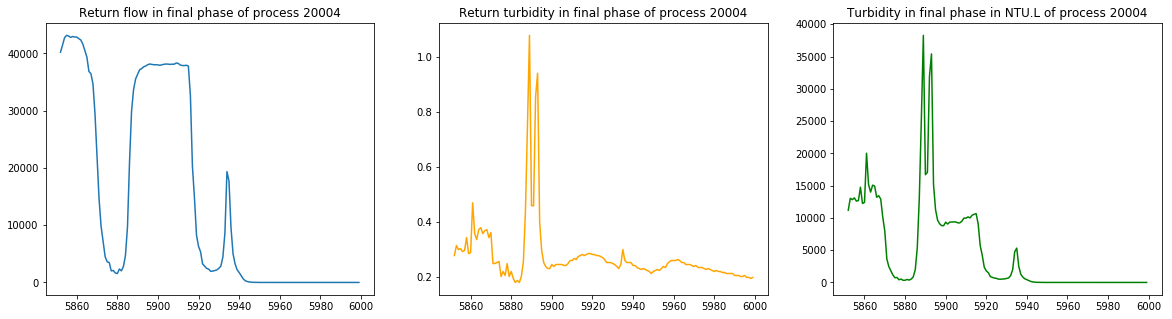

In [7]:
# plot flow, turbidity, and target 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase.return_flow)
ax[0].set_title('Return flow in final phase of process {}'.format(single_process_id))

ax[1].plot(final_phase.return_turbidity, c='orange')
ax[1].set_title('Return turbidity in final phase of process {}'.format(single_process_id))

ax[2].plot(final_phase.target, c='green')
ax[2].set_title('Turbidity in final phase in NTU.L of process {}'.format(single_process_id));

In [8]:
calculated = final_phase.target.sum()
label = train_labels.loc[single_process_id]

# confirm that our calculation and given label are equivalent:
print('Our calculation: ' + str(calculated) + '\n' + 'given label: ' + str(label) )

Our calculation: 719783.0261053684
given label: final_rinse_total_turbidity_liter    719783.026105
Name: 20004, dtype: float64


## Data exploration

The test set does not include datapoints from the final rinse, so we will exclude those in training our model.

In [9]:
train_values = train_values[train_values.phase != 'final_rinse']

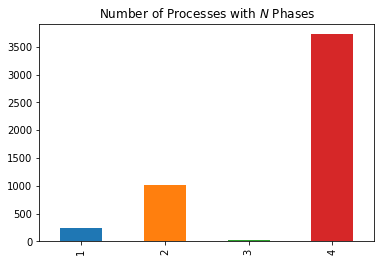

In [10]:
# visual look at how many phases we have recorded for each cleaning process
train_values.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");

On the contest homepage, we are informed that in the test set we are only given data from select previous phases (up to a given time, $t$) and then asked to predict into the future.

* For 10% of the test instances, $t$ corresponds to the end of the first (pre-rinse) phase.
* For 30% of the test instances, $t$ corresponds to the end of the second (caustic) phase.
* For 30% of the test instances, $t$ corresponds to the end of the third (intermediate rinse) phase.
* For 30% of the test instances, $t$ corresponds to the end of the fourth (acid) phase.

Taking a quick look at the graph above, it is clear that the distribution of our training set does not match the 10/30/30/30 split of our test set. This is a common problem in machine learning referred to as data mismatch. You can read more [here](https://yashuseth.blog/2018/03/20/what-to-do-when-we-have-mismatched-training-and-validation-set/).

It is crucial that the distribution of our training set match our test set as best as possible. There are many different techniques to transform/augment our data to do this (all with their own tradeoffs). Here, I've chosen to randomly drop 20% of all phases, which will bring our training/test set distributions closer to matching. It is important to acknowledge that this will have a big impact on our final model. If our model is not performing competently, this will be one of the first places I will turn to re-evaluate.

In [11]:
# create a unique phase identifier by joining process_id and phase
train_values['process_phase'] = train_values.process_id.astype(str) + '_' + train_values.phase.astype(str)
process_phases = train_values.process_phase.unique()

# randomly select 80% of phases to keep
rng = np.random.RandomState(2019)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.8),
                replace=False)

train_limited = train_values[train_values.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

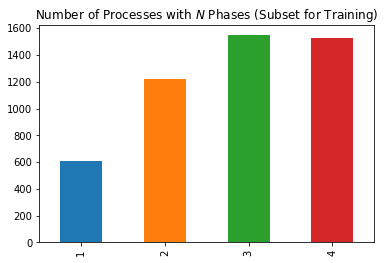

In [12]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases (Subset for Training)");

## Feature Engineering

Currently, I've split features up into 3 separate categories: `metadata`, `timeseries` and `timestamp`. I will implement  separate function to prepare each category of features.

In [14]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000))

,pipeline_L3,pipeline_L4,pipeline_L7,pipeline_L12,num_phases
process_id,,,,,
20001,0,1,0,0,4
20002,1,0,0,0,2
20003,1,0,0,0,3
20004,0,0,1,0,2
20005,0,0,1,0,1
20008,0,1,0,0,3


In [15]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

* [Great datacamp article](https://www.datacamp.com/community/tutorials/pandas-multi-index) on hierarchical-indexed (or multi-indexed) DataFrames in Pandas
    * in particular, their explanation of `.unstack()` helped a ton.
* Shoutout to [this stack overflow](https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns) for helping me to join a multi-indexed df columns into a single index, as was necessary in the next two functions.

In [25]:
# Custom time series feature we want to aggregate by
def average_derivatives(series):
    return np.gradient(series).mean()

In [28]:
# Custom time series feature we want to aggregate by
def interquartile_range(series):
    return series.quantile(0.75) - series.quantile(0.25)

In [29]:
def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols].set_index('process_id')
    
    # create features: min, max, mean, standard deviation, and mean of the last five observations
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std',
                                                   lambda x: x.tail(5).mean(),
                                                   average_derivatives,
                                                  interquartile_range])
    
    # join multi-indexed (tuple-indexed, really) columns into single index
    ts_features.columns = [' '.join(col).strip() for col in ts_features.columns.values]
    
    return ts_features

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

,supply_flow min,supply_flow max,supply_flow mean,supply_flow std,supply_flow <lambda>,supply_flow average_derivatives,supply_flow interquartile_range,supply_pressure min,supply_pressure max,supply_pressure mean,...,tank_concentration_caustic <lambda>,tank_concentration_caustic average_derivatives,tank_concentration_caustic interquartile_range,tank_concentration_acid min,tank_concentration_acid max,tank_concentration_acid mean,tank_concentration_acid std,tank_concentration_acid <lambda>,tank_concentration_acid average_derivatives,tank_concentration_acid interquartile_range
process_id,,,,,,,,,,,,,,,,,,,,,
20001,21.701390,59396.703,49501.604051,12445.724586,48618.3452,4.755267,231.48000,-0.036024,2.223741,1.673456,...,45.878381,0.000321,0.269024,39.447857,52.411568,44.711593,0.648487,44.653038,0.000219,0.540390
20002,7.233796,34295.430,27142.963425,8337.197885,29688.2238,42.190389,82.28425,-0.034071,2.170790,1.477925,...,45.269097,-0.001556,0.287860,44.216820,44.708210,44.332388,0.079575,44.229616,-0.000490,0.093877
20003,-1244.213000,103096.070,29902.913654,10872.426632,30179.3980,-6.668128,5808.73825,-0.033854,3.855469,2.630566,...,44.669835,-0.000389,0.248028,43.750900,45.270653,44.503377,0.236661,44.716846,0.000081,0.374688
20004,-43.402780,49537.035,31117.193119,13046.723480,33796.2958,47.630579,7566.55000,-0.009549,0.482422,0.287865,...,45.225381,0.000118,0.114388,44.154810,45.862520,44.835026,0.485012,45.226021,0.002288,0.979073
20005,0.000000,31295.209,28241.716353,7107.794924,30962.0944,91.031195,486.47700,-0.023438,0.487196,0.418469,...,45.739765,0.002925,0.617315,43.527600,44.412254,43.921479,0.249111,43.952939,0.001181,0.401788
20008,28638.598000,60980.902,51773.149642,8205.815088,55064.3812,-8.746230,215.20150,-0.092665,0.174913,0.167884,...,45.343967,0.000146,0.198230,44.693570,48.434254,44.821386,0.331357,44.948764,0.000247,0.087654


* Learned how to change date times to total seconds [here](https://stackoverflow.com/questions/36156582/accessing-total-seconds-in-pandas-data-column).

In [31]:
def prep_time_stamp_features(df):
    time_stamp_features = df[['process_id', 'phase', 'timestamp']].set_index('process_id')
    
    # calculates the length of each phase in each process, and stacks in multi-indexed DataFrame
    time_stamp_features = time_stamp_features.groupby(['process_id', 'phase']).agg([ lambda x: x.tail(1) - x.head(1)])
    
    # Unstacks to turn each time period for each phase into an individual feature for each process
    time_stamp_features = time_stamp_features.unstack()
    
    # fill NaT with 0's (these arise with processes that do not have all 4 cleaning phases)
    time_stamp_features = time_stamp_features.fillna(0)
    
    # Change values from timestamps to total seconds
    time_stamp_features['acid_phase_length_secs'] = time_stamp_features[('timestamp', '<lambda>', 'acid')].dt.total_seconds()
    time_stamp_features['caustic_phase_length_secs'] = time_stamp_features[('timestamp', '<lambda>', 'caustic')].dt.total_seconds()
    time_stamp_features['intermediate_rinse_phase_length_secs'] = time_stamp_features[('timestamp', '<lambda>', 'intermediate_rinse')].dt.total_seconds()
    time_stamp_features['pre_rinse_phase_length_secs'] = time_stamp_features[('timestamp', '<lambda>', 'pre_rinse')].dt.total_seconds()
    
    # drop multi-indexed (tuple-indexed, really) columns
    time_stamp_features = time_stamp_features.drop(columns=[('timestamp', '<lambda>', 'pre_rinse'), ('timestamp', '<lambda>', 'intermediate_rinse'), ('timestamp', '<lambda>', 'caustic'), ('timestamp', '<lambda>', 'acid')])
    time_stamp_features.columns = [' '.join(col).strip() for col in time_stamp_features.columns.values]
    
    return time_stamp_features

# Show example on first 5000 observations
prep_time_stamp_features(train_limited.head(5000))

,acid_phase_length_secs,caustic_phase_length_secs,intermediate_rinse_phase_length_secs,pre_rinse_phase_length_secs
process_id,,,,
20001,732.0,1454.0,128.0,528.0
20002,0.0,840.0,0.0,48.0
20003,1218.0,1940.0,276.0,0.0
20004,572.0,0.0,0.0,170.0
20005,506.0,0.0,0.0,0.0
20008,54.0,1416.0,88.0,0.0


In [97]:
# Join DataFrames outputted by each of the previous functions
def create_feature_matrix(df, recipe_metadata):
    metadata = prep_metadata(df)
    time_series = prep_time_series_features(df)
    time_stamps = prep_time_stamp_features(df)
    
    # join metadata, timestamp and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series, time_stamps], axis=1)
    
    # filtering recipe metadata to only include values that match with df
    recipe_metadata = recipe_metadata.loc[feature_matrix.index]
    
    # join recipe metadata and other features into single matrix
    feature_matrix = pd.concat([feature_matrix, recipe_metadata], axis=1)
    
    # take care of potential nans
    feature_matrix = feature_matrix.fillna(0)
    
    return feature_matrix

In [98]:
train_features = create_feature_matrix(train_limited, recipe)
train_features.head()

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,...,tank_concentration_acid interquartile_range,acid_phase_length_secs,caustic_phase_length_secs,intermediate_rinse_phase_length_secs,pre_rinse_phase_length_secs,pre_rinse,caustic,intermediate_rinse,acid,final_rinse
process_id,,,,,,,,,,,,,,,,,,,,,
20001,0,0,0,0,0,0,1,0,0,0,...,0.540390,732.0,1454.0,128.0,528.0,1,1,1,1,1
20002,0,0,0,0,0,1,0,0,0,0,...,0.093877,0.0,840.0,0.0,48.0,1,1,0,0,1
20003,0,0,0,0,0,1,0,0,0,0,...,0.374688,1218.0,1940.0,276.0,0.0,1,1,1,1,1
20004,0,0,0,0,0,0,0,0,1,0,...,0.979073,572.0,0.0,0.0,170.0,1,1,1,1,1
20005,0,0,0,0,0,0,0,0,1,0,...,0.401788,506.0,0.0,0.0,0.0,1,0,0,1,1


## Feature Exploration

Now that we have established our features, we will use the [`featexp`](https://github.com/abhayspawar/featexp) module to explore each feature individually and evaluate their utility. During this process we will split up our training set into `X_train` and `X_val`, representing training sets and validation sets, respectively. From there, we'll juxtapose the behavior of each feature in the train and validation sets with respect to the target value, `final_rinse_total_turbidity_liter`, to assess whether there is genuine signal, or just random noise.

One important piece to acknowledge is that even before splitting our data into train/val sets, we don't have a ton of data. `len(train_features) = 4902`, which is not a ton of data in the context of machine learning. We should be careful not to introduce [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/) by making feature selection decisions based on validation set data, then also training our final model of val set data.

In [99]:
import featexp

In [100]:
# This is not really splitting up into train/test, it is actually train/val
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.33, random_state=42)

In [101]:
# concat train/val values with train/val labels for easy input into featexp module
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_val, y_val], axis=1)

                                   Plots for acid_phase_length_secs                                   
                                           Train data plots                                           


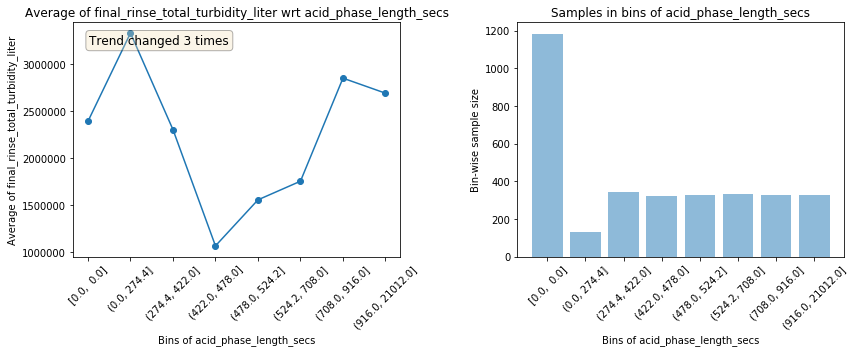

                                           Test data plots                                            


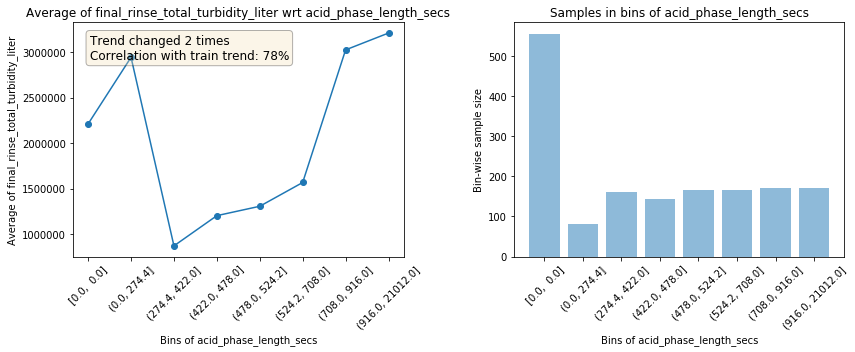

--------------------------------------------------------------------------------------------------------------




In [102]:
featexp.get_univariate_plots(data=data_train, target_col='final_rinse_total_turbidity_liter', data_test = data_test, features_list = ['acid_phase_length_secs'])

# data_test and features_list are optional. 
# Draws plots for all columns if features_list not passed
# Draws only train data plots if no test_data passed

Here, we calculate statistics on all features we've engineered and move forward with all features that have greater that .75 correlation with themselves. This .75 threshold is a somewhat arbitrary starting point which may need further tuning as we iterate through models.

In [103]:
# calculate stats on trend of each feature in train/val sets
stats = featexp.get_trend_stats(data=data_train, target_col='final_rinse_total_turbidity_liter', data_test = data_test)

# identify features that have train/val correlation > .75
useful_features = stats[stats.Trend_correlation > .75].Feature.values
print(useful_features)

Only one bin created for pipeline_L12. Correlation can't be calculated
Only one bin created for pre_rinse. Correlation can't be calculated
Only one bin created for caustic. Correlation can't be calculated
Only one bin created for final_rinse. Correlation can't be calculated
Returning stats for all numeric features
['pipeline_L1' 'pipeline_L10' 'pipeline_L11' 'pipeline_L2' 'pipeline_L3'
 'pipeline_L4' 'pipeline_L6' 'pipeline_L7' 'pipeline_L8' 'pipeline_L9'
 'num_phases' 'supply_flow min' 'supply_flow max' 'supply_flow mean'
 'supply_flow std' 'supply_flow <lambda>' 'supply_pressure min'
 'supply_pressure max' 'supply_pressure mean' 'supply_pressure std'
 'supply_pressure <lambda>' 'supply_pressure average_derivatives'
 'supply_pressure interquartile_range' 'return_temperature std'
 'return_temperature <lambda>' 'return_conductivity mean'
 'return_conductivity <lambda>' 'return_conductivity interquartile_range'
 'return_turbidity <lambda>' 'return_turbidity average_derivatives'
 'return_

## Building Model and Predicting on training data

In [104]:
# subsetting columns of train/val data to have only useful features
X_train = X_train[list(useful_features)]
X_val = X_val[list(useful_features)]

These two lines below build and train our [`AdaBoostRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html). Decision Tree-based models generally perform well in scenarios akin to ours, when we have a large number of numeric variables. I started by experimenting with Random Forests, but found better performance in this Ada-Boosted model.

In [105]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [106]:
%%time
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=50), n_estimators=100, random_state=742)

abr.fit(X_train, np.ravel(y_train))

CPU times: user 4.38 s, sys: 22.6 ms, total: 4.4 s
Wall time: 4.42 s


One unique feature of the tree-based models is that we can directly calculate just how important each feature is to our model. See graph below.

Text(0.5, 1.0, 'Importance of each feature to our model')

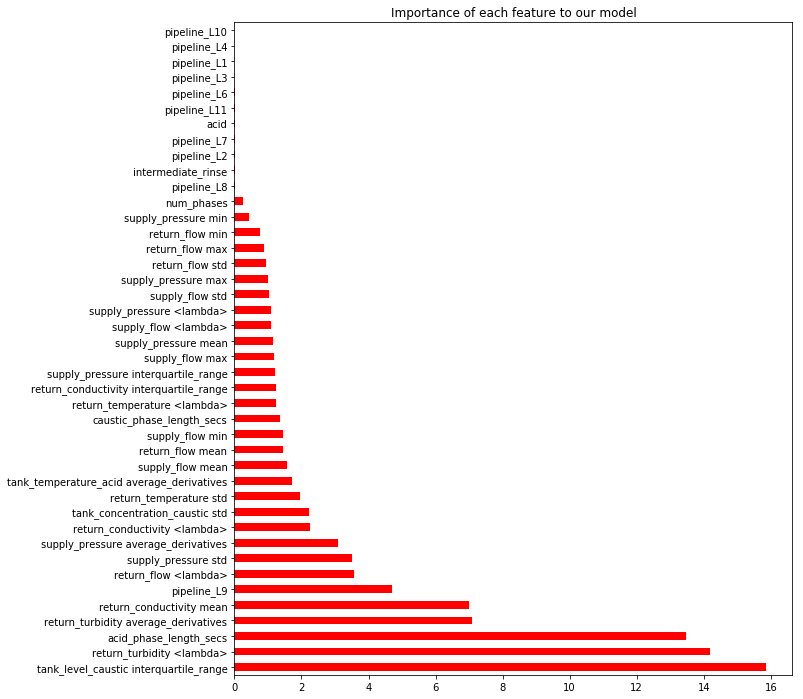

In [107]:
importance = pd.Series(abr.feature_importances_ * 100, index = X_train.columns)
importance = importance.sort_values(axis=0, ascending = False)
importance.plot(kind='barh', figsize = (10,12) ,color='r', )
plt.title('Importance of each feature to our model')

This graph tells us a lot. The first thing that sticks out is that the majority of pipelines have no predicitve power, except for `pipeline_L9`, which is our 4th most predictive feature. I would likely request more information from warehouse floor managers about pipeline L9 and whether they're aware of how clearly it indicates `final_rinse_total_turbidity_liter` relative to other pipelines. Depending on the context, it may be appropriate to leave all or most pipeline features out of our model.

Now we use our model to make predictions on our training/val sets and take a look at the performance metric, [mean absolute percentage error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error).

In [108]:
train_preds = abr.predict(X_train)

# As posted on competition website, threshold = 290000
threshold = 290000
n = len(train_preds)
mape = (1/n) * np.sum((np.abs(train_preds.reshape(n,1) - y_train.values)) / np.maximum(np.abs(y_train.values), threshold))

# Training set mean absolute percentage error
print("Mean absolute percentage error on Training Data:", mape)



val_preds = abr.predict(X_val)

# As posted on competition website, threshold = 290000
threshold = 290000
n = len(val_preds)
mape = (1/n) * np.sum((np.abs(val_preds.reshape(n,1) - y_val.values)) / np.maximum(np.abs(y_val.values), threshold))

# Training set mean absolute percentage error
print("Mean absolute percentage error on Validation Data:", mape)

Mean absolute percentage error on Training Data: 0.1886615952239438
Mean absolute percentage error on Validation Data: 0.497210762438442


Overall, these are a decent predictions that would be sufficient for most use-cases. In particular, the length of training time (only 3.51 secs) is a huge bonus. We may be able to marginally improve these predictions by experimenting with some gradient-boosted Decision Tree-based models, but we would pay a significant cost in time required to train the model. 

One approach that we have not attempted is to feed the raw sensor data into a deep neural net. Training time would again be long, but it's possible that this could yield a much improved model. I would only building a custom neural net for this when very high accuracy is mission-critical, and alternative feature engineering ideas have been exhausted.

## Preparing Prediction Submission

In [65]:
# load the test data
test_values = pd.read_csv('../data/raw/test_values.csv', index_col = 0, parse_dates=['timestamp'])

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [109]:
# create metadata and time series features and time stamp features
test_features = create_feature_matrix(test_values, recipe)

# subset test_features to only include useful features
test_features = test_features[list(useful_features)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


In [110]:
# Make Predictions
pred_1_2 = abr.predict(test_features)

In [111]:
submission_format = pd.read_csv('../data/raw/submission_format.csv', index_col= 0)

In [113]:
# confirm everything is in the right order
assert np.all(test_features.index == submission_format.index)

In [114]:
pred_1_2 = pd.DataFrame(data = pred_1_2, columns=submission_format.columns,index = submission_format.index)

In [115]:
pred_1_2.head()

,final_rinse_total_turbidity_liter
process_id,
20000,1.476096e+06
20006,1.111978e+06
20007,1.109852e+06
20009,1.308202e+06
20010,6.611908e+05


In [116]:
pred_1_2.to_csv('../models/pred_1.2.csv')

In [117]:
!head ../models/pred_1.2.csv

process_id,final_rinse_total_turbidity_liter
20000,1476096.223592035
20006,1111978.438698327
20007,1109851.694641845
20009,1308202.239947156
20010,661190.7572811783
20012,653208.4572713246
20013,101705.78418200984
20015,237499.31862240372
20020,828641.2554670094
